In [1]:
import os
import dmd
# os.environ["OMP_NUM_THREADS"]='4'
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.linalg import pinv, svd, eig, svdvals
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

In [2]:
# N=10000
# K=2
# seed=1
# c=1
# t1=100
# dt=1E-2
# atol=1E-10
# fs=np.zeros(N+2)
# ns=[0,1,-1]
# omega=np.zeros(N)

# filebase='data/dmd1'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

# K=2
# c=1.75
# filebase='data/dmd2'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

# K=N
# c=1.75
# filebase='data/dmd3'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

In [3]:
# os.system('./dmd2.py --pcatol 1E-7 --filebase data/dmd1/')
# os.system('./dmd2.py --pcatol 1E-7 --filebase data/dmd2/')
# os.system('./dmd2.py --pcatol 1E-7 --filebase data/dmd3/')

# os.system('./dmd.py --pcatol 1E-7 --filebase data/dmd4/')
# os.system('./dmd.py --pcatol 1E-7 --filebase data/dmd5/')
# os.system('./dmd.py --pcatol 1E-7 --filebase data/dmd6/')

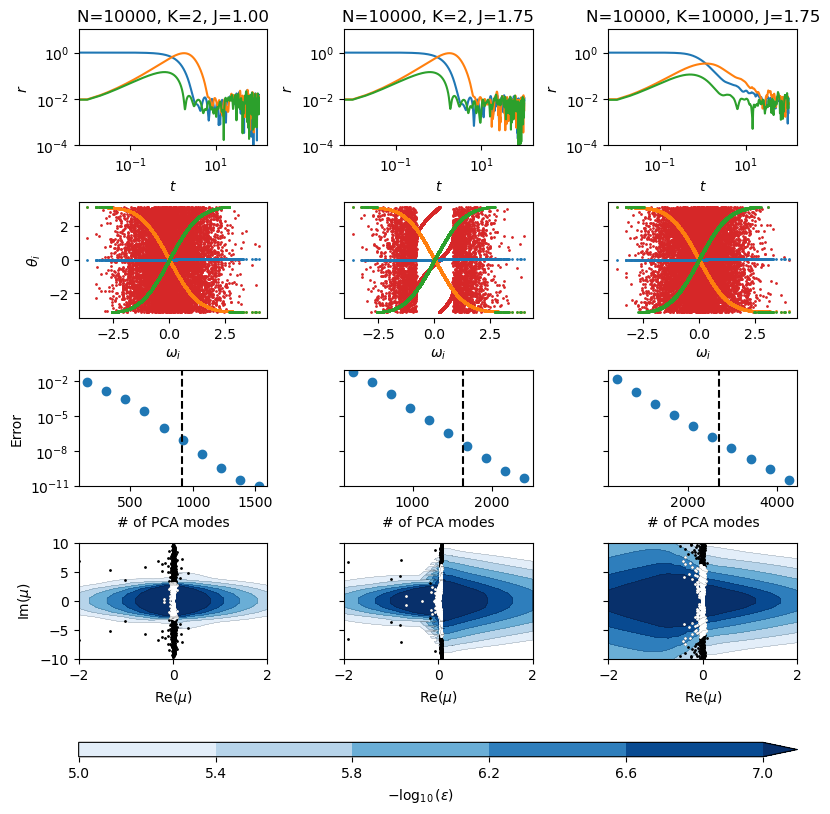

In [4]:
# filebases=['data/dmd1/','data/dmd2/','data/dmd3/']
filebases=['data/dmd4/','data/dmd5/','data/dmd6/']
fig,axs=plt.subplots(4,3,figsize=(8,8) ,constrained_layout=True)

m=0
for filebase0 in filebases:
    for n in range(3):
        filebase='%s/%i'%(filebase0,n)
        file=open(filebase+'.out')
        lines=file.readlines()
        N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
        N=int(N)
        K=int(K)
        file.close()
    
        omega=np.fromfile(filebase+'frequencies.dat',dtype=np.float64)
        N=len(omega)
        thetas=np.fromfile(filebase+'thetas.dat',dtype=np.float64).reshape((-1,N))
        thetas=thetas-np.mean(omega)*dt*np.arange(thetas.shape[0])[:,np.newaxis]
        orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
    
        plt.subplot(4,3,1+m)
        plt.plot(dt*np.arange(orders.shape[0]),orders)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('$t$')
        plt.ylabel('$r$')
        plt.ylim(1E-4,1E1)
        plt.title('N=%i, K=%i, J=%.2f'%(N, K,c))
        plt.subplot(4,3,4+m)
        plt.scatter(omega,np.mod(thetas[0]+np.pi,2*np.pi)-np.pi,s=1,zorder=5)
        plt.xlabel('$\omega_i$')
        if m>0:
            plt.gca().set_yticklabels([])
        else:
            plt.ylabel(r'$\theta_i$')
        
    plt.scatter(omega,np.mod(thetas[-1]+np.pi,2*np.pi)-np.pi,s=1,zorder=3)
    
    plt.subplot(4,3,7+m)
    plt.scatter(*np.fromfile('%s/errs.dat'%(filebase0)).reshape((2,-1)))
    plt.yscale('log')
    plt.xlabel('# of PCA modes')
    if m>0:
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Error')
    r=np.fromfile('%s/evals.dat'%(filebase0),dtype=np.complex128).shape
    plt.ylim(1E-11,1E-1)
    
    plt.plot([r,r],[1E-11,1E-1],c='black',ls='--')
    
    vals1=np.fromfile('%s/pseudo.dat'%(filebase0))
    zs1=np.fromfile('%s/zs.dat'%(filebase0),dtype=np.complex128)
    nr=26
    ni=26
    
    resmin=1E-5
    resmax=1E-7
    rescrit=1E-6
    levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5
    
    plt.subplot(4,3,10+m)
    cs1 = plt.gca().tricontourf(np.real(np.log(zs1)/dt),np.imag(np.log(zs1)/dt),np.log(1/np.array(vals1))/np.log(10),levels=levels,cmap='Blues',extend='max')
    cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1)
    
    xs1=np.real(np.log(zs1[:-nr*ni])/dt)
    ys1=np.imag(np.log(zs1[:-nr*ni])/dt)
    inds=np.where(vals1[:-nr*ni]<rescrit)[0]
    plt.scatter(xs1,ys1,c='black',s=1)
    plt.scatter(xs1[inds],ys1[inds],c='white',s=1)
    # plt.ylim(-3,3)
    # plt.xlim(-0.6,0.6)
    if m>0:
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('$\mathrm{Im}({\mu})$')
    plt.xlabel('$\mathrm{Re}({\mu})$')
    m=m+1

fig.colorbar(cs1, ax=axs[:4,:3], location='bottom',aspect=50,label=r'$-\log_{10}(\varepsilon)$')

plt.savefig('dmd.pdf')
plt.show()

### Mode amplitudes

./kuramoto_64 -N 10000 -K 2 -c 1.000000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd4/0 

runtime: 58.943239

./kuramoto_64 -N 10000 -K 2 -c 1.000000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd4/1 

runtime: 58.639726

./kuramoto_64 -N 10000 -K 2 -c 1.000000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd4/2 

runtime: 58.900044

./kuramoto_64 -N 10000 -K 2 -c 1.750000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd5/0 

runtime: 77.954241

./kuramoto_64 -N 10000 -K 2 -c 1.750000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd5/1 

runtime: 78.169905

./kuramoto_64 -N 10000 -K 2 -c 1.750000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd5/2 

runtime: 78.339968

./kuramoto_64 -N 10000 -K 10000 -c 1.750000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd6/0 

runtime: 149.627069

./kuramoto_64 -N 10000 -K 10000 -c 1.750000 -t 100.000000 -d 0.010000 -s 1 -a 

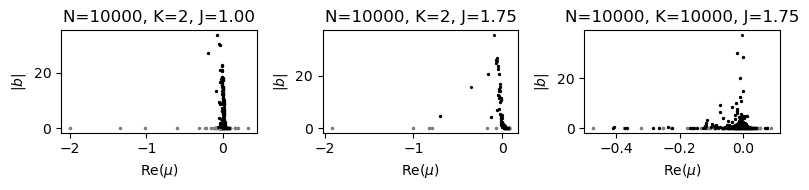

In [5]:
filebases=['data/dmd4/','data/dmd5/','data/dmd6/']
nr=26
ni=26
rescrit=1E-6


l=1
plt.subplots(1,3,figsize=(8,2))

for filebase0 in filebases:
    thetas=[]
    n=0
    while os.path.exists('%s%i.out'%(filebase0,n)):
        filebase='%s%i'%(filebase0,n)
        file=open(filebase+'.out')
        lines=file.readlines()
        N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
        N=int(N)
        K=int(K)
        print(lines[1])
        print(lines[-1])
        file.close()
    
        omega=np.fromfile(filebase+'frequencies.dat',dtype=np.float64)
        N=len(omega)
        theta=np.fromfile(filebase+'thetas.dat',dtype=np.float64).reshape((-1,N))
        theta=theta-np.mean(omega)*dt*np.arange(theta.shape[0])[:,np.newaxis]
        thetas=thetas+[theta]
        n=n+1
    rs=np.concatenate([np.abs(np.mean(np.exp(1j*theta),axis=1))[:-1,np.newaxis] for theta in thetas],axis=0)
    Thetas=np.concatenate([np.unwrap(np.angle(np.mean(np.exp(1j*theta),axis=1)))[:-1,np.newaxis] for theta in thetas],axis=0)
    X=np.concatenate([thetas[i][:-1] for i in range(len(thetas))],axis=0)
    X=np.concatenate([np.cos(X),np.sin(X),rs,np.cos(Thetas),np.sin(Thetas)],axis=1)

    rs=np.concatenate([np.abs(np.mean(np.exp(1j*theta),axis=1))[1:,np.newaxis] for theta in thetas],axis=0)
    Thetas=np.concatenate([np.unwrap(np.angle(np.mean(np.exp(1j*theta),axis=1)))[1:,np.newaxis] for theta in thetas],axis=0)
    Y=np.concatenate([thetas[i][1:] for i in range(len(thetas))],axis=0)
    Y=np.concatenate([np.cos(Y),np.sin(Y),rs,np.cos(Thetas),np.sin(Thetas)],axis=1)
    
    s=np.fromfile('%ss.dat'%(filebase0),dtype=np.float64)
    rank=len(s)
    u=np.fromfile('%su.dat'%(filebase0),dtype=np.float64).reshape((-1,rank))
    v=np.fromfile('%sv.dat'%(filebase0),dtype=np.float64).reshape((rank,-1))
    evals=np.fromfile('%sevals.dat'%(filebase0),dtype=np.complex128)
    r=len(evals)
    evecs=np.fromfile('%sevecs.dat'%(filebase0),dtype=np.complex128).reshape((-1,r))
    res=np.fromfile('%sres.dat'%(filebase0),dtype=np.complex128)
    vals=np.fromfile('%spseudo.dat'%(filebase0),dtype=np.float64)
    xis=np.fromfile('%sxis.dat'%(filebase0),dtype=np.complex128).reshape((-1,r)).T
    zs=np.fromfile('%szs.dat'%(filebase0),dtype=np.complex128)
    
    
    U=u[:,:r]
    V=v[:r,:]
    S=s[:r]
    vs=(np.conjugate(V).T*1/S).dot(xis)
    
    
    inds=np.where(vals[:-nr*ni]<rescrit)[0]
    xs=np.real(np.log(zs[:-nr*ni])/dt)
    ys=np.imag(np.log(zs[:-nr*ni])/dt)
    rs=(xs**2+ys**2)**0.5
    bs=np.abs(X[0].dot(vs[:,:-nr*ni])/np.linalg.norm(vs[:,:-nr*ni],axis=0))
    bsn=np.abs(X[n].dot(vs[:,:-nr*ni])/np.linalg.norm(vs[:,:-nr*ni],axis=0)/zs[:-nr*ni]**n)
    
    plt.subplot(1,3,l)
    plt.scatter(xs,bs,c='grey',s=2)
    plt.scatter(xs[inds],bs[inds],c='black',s=1)
    plt.title('N=%i, K=%i, J=%.2f'%(N, K,c))
    plt.xlabel(r'$\mathrm{Re}(\mu)$')
    plt.ylabel(r'$|b|$')
    # plt.xlim(-2,2)
    # plt.ylim(0,60)
    l=l+1
    
    np.savetxt(filebase0+'amplitudes.txt',np.vstack([xs,ys,rs,bs,bsn,vals[:-nr*ni]]).T)

plt.tight_layout()
plt.savefig('modeamplitudes.pdf')
plt.show()

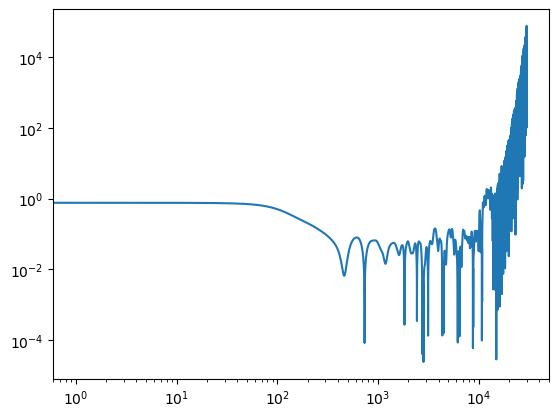

In [6]:
inds=np.where(vals[:-nr*ni]<rescrit)[0]
bs=X[0].dot(vs[:,:-nr*ni])
Xreconstruct2=(zs[inds][:,np.newaxis]**np.arange(len(X))[np.newaxis,:]).T.dot(bs[inds,np.newaxis]*np.linalg.pinv(vs[:,inds]))
plt.plot(np.abs(Xreconstruct2[:,-3]))
plt.plot(X[:,-3])
plt.xscale('log')
plt.yscale('log')

In [ ]:
bs=X[0].dot(vs[:,:-nr*ni])
Xreconstruct=(zs[:-nr*ni][:,np.newaxis]**np.arange(len(X))[np.newaxis,:]).T.dot(bs[:-nr*ni,np.newaxis]*np.linalg.pinv(vs[:,:-nr*ni]))
plt.plot(np.abs(Xreconstruct[:,-3]))
plt.plot(X[:,-3])
plt.xscale('log')
plt.yscale('log')

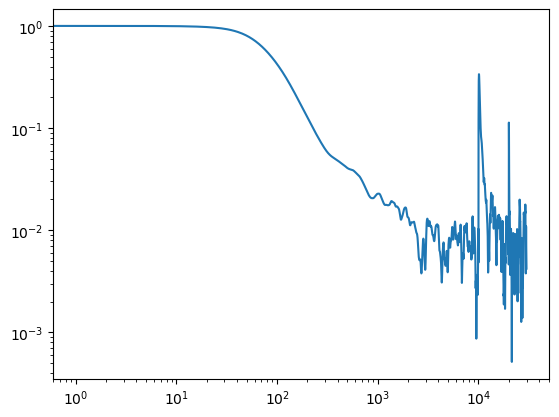

In [19]:
plt.plot(X[:,-3])
plt.xscale('log')
plt.yscale('log')

### Mode amplitude and mode details for a single DMD mode. Note that the peaks around \pm 1 correspond to perturbed version of the uncoupled Koopman mode, which is a Dirac delta peak

694 (0.9912959279436632-0.005685059098291205j) 4.409399963671041e-07


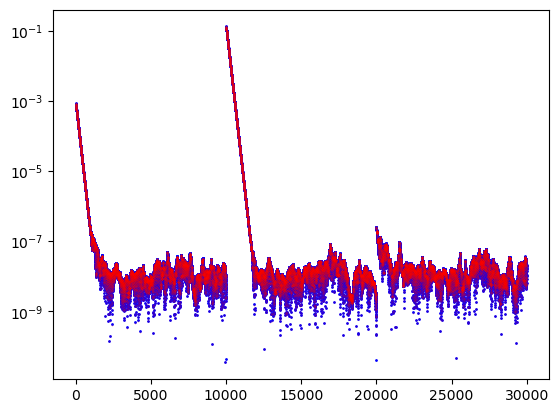

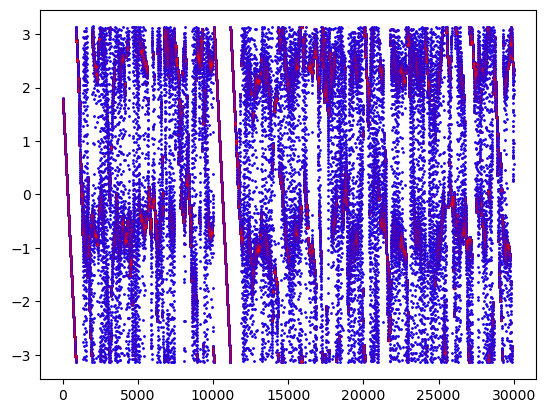

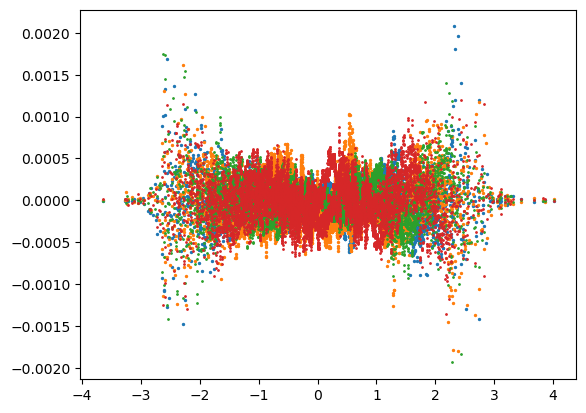

In [44]:
vs=(np.conjugate(V).T*1/S).dot(xis)
i=np.argsort(vals[:-26*26])[2]
print(i,zs[i],vals[i])
plt.plot(np.abs(Y.dot(vs[:,i])),'bo',ms=1)
plt.plot(np.abs(zs[i]*X.dot(vs[:,i])),'ro',ms=0.1)
plt.yscale('log')
plt.show()
plt.plot((np.angle(Y.dot(vs[:,i]))),'bo',ms=1)
plt.plot((np.angle(zs[i]*X.dot(vs[:,i]))),'ro',ms=0.1)
plt.show()

plt.scatter(omega,np.real(vs[:N,i]),s=2)
plt.scatter(omega,np.imag(vs[:N,i]),s=2)
plt.scatter(omega,np.real(vs[N:,i]),s=1)
plt.scatter(omega,np.imag(vs[N:,i]),s=1)
plt.show()